# Setup

In [1]:
from fastai.data.block import DataBlock
!pip install -Uqq fastbook
import fastbook

fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *



# Download Images

In [ ]:
path = Path('/home/dant/data/not_pepper')
image_types = ['black dogs', 'dogs', 'cats', "black cats", "bears", "german shepherds"]

if not path.exists():
    path.mkdir()

In [ ]:

for o in image_types:
    results = search_images_ddg(o)
    print(f"Dowloading images with description: {o}")
    download_images(path, urls=results)


# Cleanup

In [2]:
path = Path('/home/dant/data')
fns = get_image_files(path)
len(fns)

8450

In [3]:
failed = verify_images(fns)
len(failed)

2

In [4]:
failed.map(Path.unlink);


# Train

In [5]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.8), batch_tfms=aug_transforms())


In [6]:
dls = db.dataloaders(path)

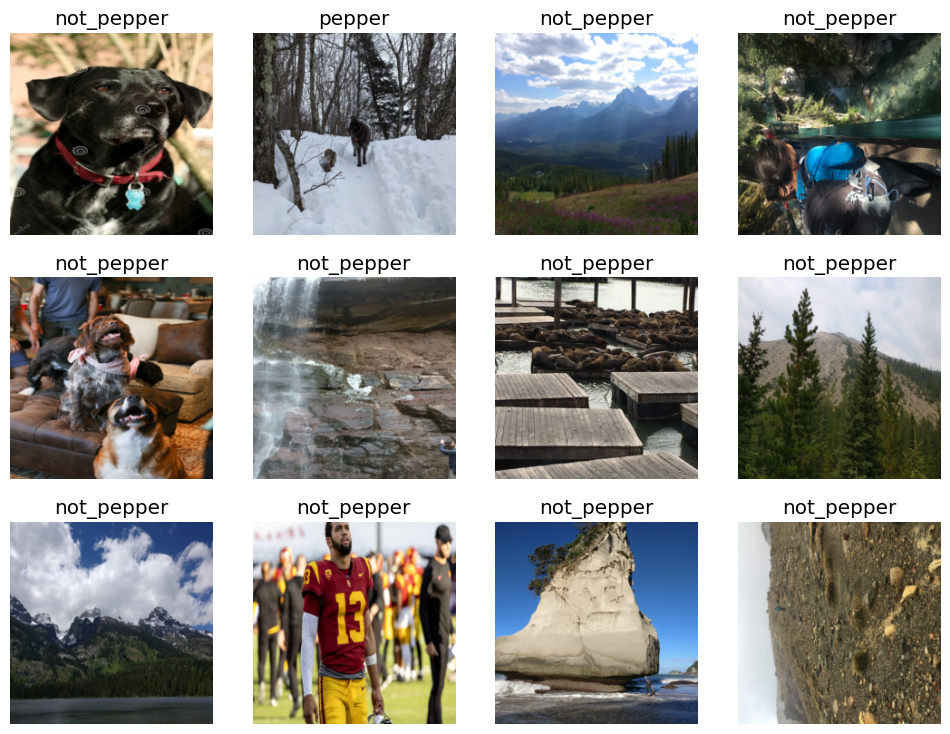

In [7]:

dls.valid.show_batch(max_n=12, nrows=3, unique=False)

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(12)

epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time
0,0.364888,0.152944,0.046773,00:44


epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46
3,0.056743,0.056364,0.015394,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46
3,0.056743,0.056364,0.015394,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46
3,0.056743,0.056364,0.015394,00:46
4,0.040183,0.049645,0.015394,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46
3,0.056743,0.056364,0.015394,00:46
4,0.040183,0.049645,0.015394,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46
3,0.056743,0.056364,0.015394,00:46
4,0.040183,0.049645,0.015394,00:46
5,0.028155,0.058447,0.012433,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46
3,0.056743,0.056364,0.015394,00:46
4,0.040183,0.049645,0.015394,00:46
5,0.028155,0.058447,0.012433,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46
3,0.056743,0.056364,0.015394,00:46
4,0.040183,0.049645,0.015394,00:46
5,0.028155,0.058447,0.012433,00:45
6,0.029477,0.049620,0.013025,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46
3,0.056743,0.056364,0.015394,00:46
4,0.040183,0.049645,0.015394,00:46
5,0.028155,0.058447,0.012433,00:45
6,0.029477,0.049620,0.013025,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46
3,0.056743,0.056364,0.015394,00:46
4,0.040183,0.049645,0.015394,00:46
5,0.028155,0.058447,0.012433,00:45
6,0.029477,0.049620,0.013025,00:45
7,0.023369,0.028296,0.006513,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46
3,0.056743,0.056364,0.015394,00:46
4,0.040183,0.049645,0.015394,00:46
5,0.028155,0.058447,0.012433,00:45
6,0.029477,0.049620,0.013025,00:45
7,0.023369,0.028296,0.006513,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46
3,0.056743,0.056364,0.015394,00:46
4,0.040183,0.049645,0.015394,00:46
5,0.028155,0.058447,0.012433,00:45
6,0.029477,0.049620,0.013025,00:45
7,0.023369,0.028296,0.006513,00:46
8,0.013587,0.037517,0.010065,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46
3,0.056743,0.056364,0.015394,00:46
4,0.040183,0.049645,0.015394,00:46
5,0.028155,0.058447,0.012433,00:45
6,0.029477,0.049620,0.013025,00:45
7,0.023369,0.028296,0.006513,00:46
8,0.013587,0.037517,0.010065,00:46
9,0.013100,0.029451,0.008881,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46
3,0.056743,0.056364,0.015394,00:46
4,0.040183,0.049645,0.015394,00:46
5,0.028155,0.058447,0.012433,00:45
6,0.029477,0.049620,0.013025,00:45
7,0.023369,0.028296,0.006513,00:46
8,0.013587,0.037517,0.010065,00:46
9,0.013100,0.029451,0.008881,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46
3,0.056743,0.056364,0.015394,00:46
4,0.040183,0.049645,0.015394,00:46
5,0.028155,0.058447,0.012433,00:45
6,0.029477,0.049620,0.013025,00:45
7,0.023369,0.028296,0.006513,00:46
8,0.013587,0.037517,0.010065,00:46
9,0.013100,0.029451,0.008881,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46
3,0.056743,0.056364,0.015394,00:46
4,0.040183,0.049645,0.015394,00:46
5,0.028155,0.058447,0.012433,00:45
6,0.029477,0.049620,0.013025,00:45
7,0.023369,0.028296,0.006513,00:46
8,0.013587,0.037517,0.010065,00:46
9,0.013100,0.029451,0.008881,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.120258,0.077605,0.023091,00:46
1,0.080958,0.064263,0.019538,00:45
2,0.056736,0.061818,0.013025,00:46
3,0.056743,0.056364,0.015394,00:46
4,0.040183,0.049645,0.015394,00:46
5,0.028155,0.058447,0.012433,00:45
6,0.029477,0.049620,0.013025,00:45
7,0.023369,0.028296,0.006513,00:46
8,0.013587,0.037517,0.010065,00:46
9,0.013100,0.029451,0.008881,00:46


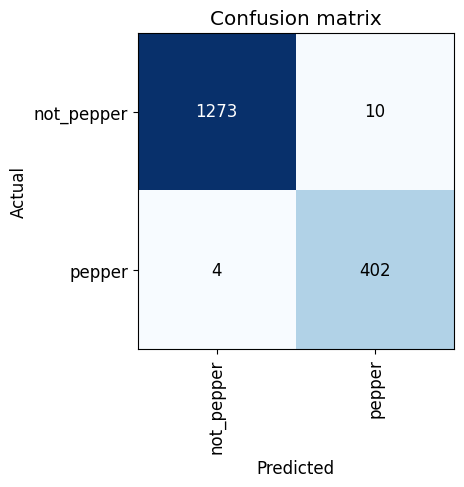

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=4)


In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path / cat)

In [10]:
learn.export("/tmp/model.pkl")

# After Training

In [ ]:
#/export
from fastai.vision.all import *
import gradio as gr

learn = load_learner("model.pkl")

In [ ]:
im = PILImage.create("images/dog1.jpg")
im.thumbnail((128, 128))
im

In [ ]:
learn.predict(im)

In [ ]:
#/export

def classify_image(img):
    pred, idx, prob = learn.predict(img)
    return dict(zip(learn.dls.vocab, map(float, prob)))


In [ ]:
classify_image(im)

In [ ]:
#/export
image = gr.Image(height=224, width=224)
label = gr.Label()

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label)
intf.launch(inline=False)